# PyMUV Tutorial
PyMUV's main class, `FeatureSelector`, implements the minimally biased variable selection algorithm. For more details regarding the algorithm, please refer to the original paper linked on the project's README. 

# 1. Setup

## 1.1. Imports and client setup
We start importing `FeatureSelector` from `pymuvr`and setting up a Dask cluster to enable parallel computation.
The cluster will run on our local machine and a dashboard that shows the state of the computation will be will be available at http://localhost:8787/status.

In [1]:
from pymuvr import FeatureSelector

In [2]:
from dask.distributed import Client
client = Client()
executor = client.get_executor()

## 1.2. Load the data
For this tutorial, we'll use the "mosquito" database (_Buck M. et al. (2016) Bacterial associations reveal spatial population dynamics in Anopheles gambiae mosquitoes. Sci. Rep., 6, 22806._). The database represents 29 measurements of operational taxonomic units (OTU) performed on mosquitoes. The target variable ("Yotu") is the village where the mosquitoes have been collected.

In [3]:
import pandas as pd
df = pd.read_csv("mosquito.csv", index_col=0)
df.head()

,OTU_0,OTU_1,OTU_2,OTU_3,OTU_4,OTU_5,OTU_6,OTU_7,OTU_8,OTU_9,...,OTU_6670,OTU_6675,OTU_6681,OTU_6685,OTU_6686,OTU_6691,OTU_6693,OTU_6702,OTU_6709,Yotu
sample_id,,,,,,,,,,,,,,,,,,,,,
VK5_9,1861,0,7,4,993,0,202,0,0,15,...,0,0,0,0,0,0,0,0,0,VK5
VK5_3,249,0,10,0,1254,0,3954,0,1,26,...,0,0,0,0,0,0,0,0,0,VK5
VK3_43,922,0,13,27,0,0,0,0,0,43,...,0,0,0,0,0,0,0,0,0,VK3
VK7_26,84,0,57,29,2,0,9,0,0,101,...,0,0,0,0,0,0,0,0,1,VK7
VK5_4,220,0,5,1,556,0,4206,0,0,616,...,0,0,0,0,0,0,0,0,0,VK5


We have to separate the predictors variables `X` (OTUs) from the target variable `y` ("Yotu").

In [4]:
X = df.drop(columns=["Yotu"]).values
y = df.Yotu.values

---

# 2. Run Feature Selection

## 2.1 Choose the estimator and the performance metric
The estimator parameter is the machine learning model used to evaluate the features. PyMUV supports a few estimators as strings like `"RFC"`, scikit-learn implementation of random forest classifier. Alternatively, pymuvr supports other scikitlearn objects like regular estimators or pipelines.

The metrics supported by pymuvr as strings are scikit-learn metrics and the MISS score. Alternatively, it is possible to pass a function that returns the metric score.

In [5]:
estimator = "RFC"
metric = "MISS"

Now we are ready to perform the feature selection. First of all we instantiate the feature selector class. To keep the algorithm runtime short, we'll specify few repetitions, few CV splits and a high feature dropout rate (the fraction of features dropped at every step of the recursive feature elimination). In a real case scenario, a higher number of repetitions and a lower dropout rate would be appropriate.

In [16]:
fs = FeatureSelector(
    n_outer=6,
    n_inner=5,
    n_repetitions=8,
    metric=metric,
    estimator=estimator,
    features_dropout_rate=0.05,
    random_state=1
)

In [17]:
fs.fit(X, y, executor=executor)

2021-03-08 11:41:09 pymuvr.feature_selector   INFO    Groups parameter is not specified: independent samples assumed
2021-03-08 11:41:09 pymuvr.feature_selector   INFO    Running 8 repetitions and 6 outer loops using executor ClientExecutor.
2021-03-08 11:41:09 pymuvr.feature_selector   INFO    Scheduling tasks...


100% (48 of 48) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


2021-03-08 11:41:09 pymuvr.feature_selector   INFO    Retrieving results...


100% (48 of 48) |########################| Elapsed Time: 0:15:22 Time:  0:15:22


2021-03-08 11:56:31 pymuvr.feature_selector   INFO    Finished feature selection.


FeatureSelector(repetitions=8, n_outer=6, n_inner=5, feature_dropout_rate=0.05, is_fit=True)

### Sample correlation
The fit method will assume that every sample is independent from the others. If the samples are correlated, e.g. they belong to the same patients, an additional vector `groups` should be passed to the fit method:
```python
>>> groups
numpy.array([1, 1, 1, 2, 2, ..., 3, 1, 2])
>>> fs.fit(X, y, groups=groups)
```
This vector would represent the group (as integer index) to which each sample belongs.

Now we can call the method `fit`, that would actually compute the selected features. Features will be also available as attributes as `selected_features`.

---

# 3. Results
The selected features can be obtained by calling `fs.get_selected_features(feature_names)` with the optional parameter of `feature_names`. The returned object contains the min, mid and max feature sets.

In order to return the selected feature names you must provide the list of feature names of the input data. If the names aren't provided, the feature indices are returned.

In [18]:
feature_names = df.drop(columns=["Yotu"]).columns

selected_features = fs.get_selected_features()
selected_feature_names = fs.get_selected_features(feature_names)

In [19]:
print(selected_features["min"])

[26, 4, 245, 1138, 167, 14, 37, 570, 98, 24, 134]


In [20]:
print(selected_feature_names["min"])

['OTU_28', 'OTU_4', 'OTU_400', 'OTU_3454', 'OTU_243', 'OTU_16', 'OTU_39', 'OTU_1208', 'OTU_114', 'OTU_26', 'OTU_178']


## 3.1 Feature ranks dataframe

You can also get a dataframe of the average feature ranks across repetitions and outerloops using `get_average_ranks_df`:

In [21]:
feature_ranks_df = fs.get_average_ranks_df(feature_names)
feature_ranks_df.head()

,min,mid,max
OTU_0,NaN,54,53.125
OTU_1,NaN,NaN,359.889
OTU_2,46,57.25,102
OTU_3,NaN,45,78.3636
OTU_4,3.53846,3.76744,3.73913


## 3.2. Feature Selection Results

This object contains data obtained from running the feature selection. This data is used for the plotting functions and can be used for further analysis. The attributes are:
- `selected_features`: the list of selected features for feature sets "min", "mid" and "max"
- `selected_feature_names`: the list of selected features names for feature sets "min", "mid" and "max"
- `score_curves`: the validation score curves 
- `raw_results`: the unprocessed results of the algorithm

In [22]:
feature_selection_results = fs.get_feature_selection_results(feature_names)

---

# 4. Plots

PyMUV offers plots to visualize the results of the feature selection. The plots supported are:
- Validation curve
- Feature ranks

In [23]:
from pymuvr.plot_utils import plot_validation_curves, plot_feature_rank

### Validation Curves

The validation curves show different levels of granularity of the results and what results from their aggregation. 

The vertical lines mark the three feature sets: MIN, MID and MAX.

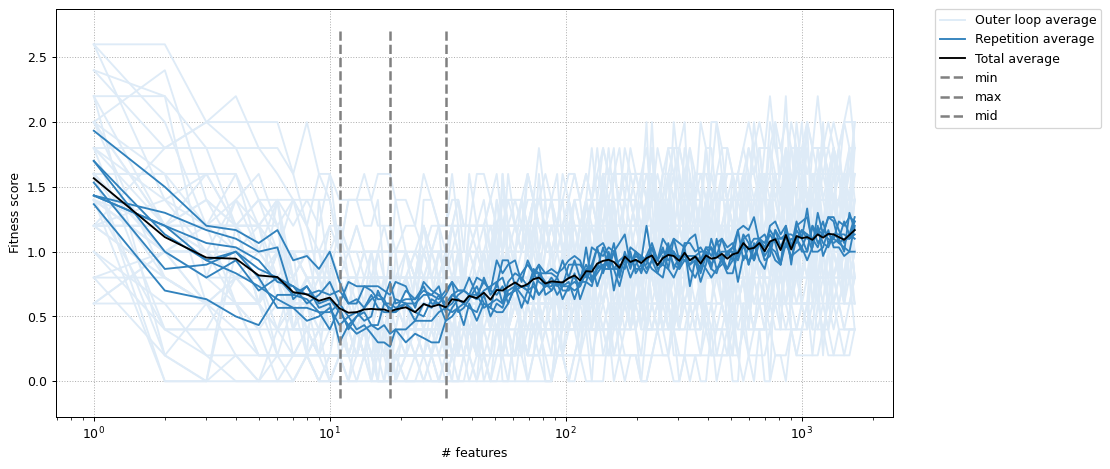

In [24]:
_ = plot_validation_curves(feature_selection_results, figsize=(12,6), dpi=90)

### Feature Ranks

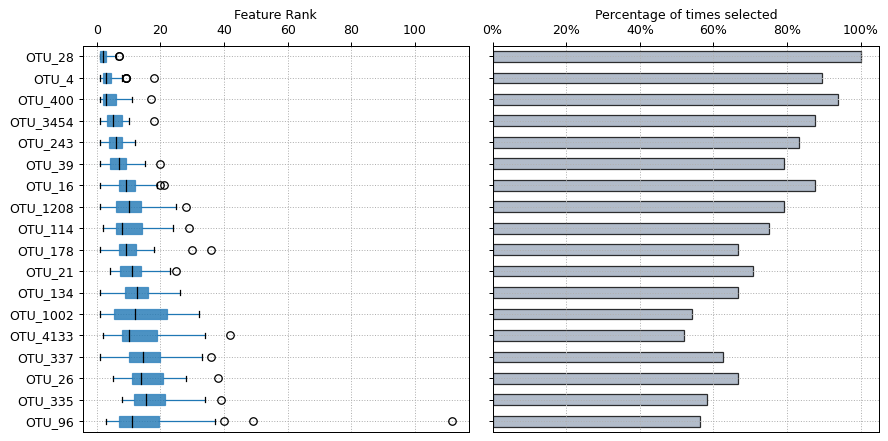

In [25]:
_ = plot_feature_rank(feature_selection_results, "mid", feature_names=feature_names, figsize=(10, 5), dpi=90)

# 5. Permutation Test

To assess the statistical significance of the selected features, PyMUV provides a PermutationTest class.

In [15]:
from pymuvr.permutation_test import PermutationTest

permutation_test = PermutationTest(fs, n_permutations=4)
permutation_test.fit(X, y)

2021-01-21 15:51:51 pymuvr.permutation_test   INFO    Running permutation test for 4 permutations


100% (4 of 4) |##########################| Elapsed Time: 0:07:53 Time:  0:07:53


2021-01-21 15:59:45 pymuvr.permutation_test   INFO    Finished permutation test. Storing results in self.res_perm


PermutationTest(n_permutations=4)

In [16]:
feature_set = "min"
p_value = permutation_test.compute_p_values(feature_set)
print("Feature set '%s' p-value: %g" % (feature_set, p_value))

Feature set 'min' p-value: 0.00546747


Since the p-value is small enough, we can be confident about the feature selection being significant. However, in a real case scenario, many more permutation would be needed.

# 6. Saving results

You can save the feature ranks dataframe as csv by using `export_average_feature_ranks`:

In [17]:
_ = fs.export_average_feature_ranks("feature_ranks.csv", feature_names)

# Cleanup
Finally we can close the cluster client

In [18]:
client.close()